In [247]:
# import package
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer

import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

# Data processing pipeline

## Dataset: German credit
German credit là bộ dữ liệu về lịch sử tín dụng của 1000 tài khoản khác nhau. Mục tiêu của chúng ta là dựa vào lịch sử tín dụng này để dự đoán khả năng khách hàng sẽ trả nợ hay không. Bộ dữ liệu bao gồm 20 biến đầu vào trong đó có 7 biến liên tục (numeric) và 13 biến phân loại (category). Nội dung của các biến từ 1 đến 20 lần lượt như sau:

- `StaAcc`: Trạng thái tài khoản hiện có.
- `DuMon`: Kỳ hạn theo tháng (Duration)
- `CredHis`: Lịch sử tín dụng
- `Purpose`: Mục đích
- `CredAmt`: Dư nợ tín dụng (Credit amount)
- `SavAcc`: Tài khoản tiết kiệm (Savings account)
- `PreEmpl`: Số năm làm việc liên tục gần nhất tới thời điểm hiện tại
- `InsRt`: Tỷ lệ trả góp (Installment rate) theo thu nhập khả dụng
- `PerSta`: Giới tính và trạng thái hôn nhân
- `OthDebtor`: Những người nợ khác
- `PreRe`: Thời gian cư trú tại nơi ở hiện tại
- `Property`: Bất động sản
- `Age`: Tuổi
- `IntPla`: Trả góp khác
- `Housing`: Nhà ở
- `ExstCredit`: Số lượng khoản vay tại ngân hàng
- `Job`: Nghề nghiệp
- `NoMain`: Số người phụ thuộc
- `Phone`: Điện thoại
- `ForWorker`: Có phải là lao động nước ngoài
- `Response`: Biến mục tiêu (cột response ở vị trí cuối cùng) có giá trị 1 cho khách hàng Good và 2 cho khách hàng Bad. Khách hàng Good là khác hàng vỡ nợ và chúng ta còn gọi là Negative Class trong khi khách hàng Bad là trường hợp ngược lại và là Positive class.

Đây là bộ dữ liệu mất cân bằng khi nhãn Good (Negative) chiếm 70% và nhãn Bad chỉ 30% (Positive)

In [171]:
df_raw = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", 
                 header=None, names=['StaAcc', 'DuMon', 'CredHis', 'Purpose', 'CredAmt', 'SavAcc', \
                                     'PreEmpl', 'InsRt', 'PerSta', 'OthDebtor', 'PreRe', 'Property', \
                                     'Age', 'IntPla', 'Housing', 'ExstCredit', 'Job', 'NoMain', 'Phone', 'ForWorker', "Response"], 
                 index_col=None, sep=" ")
df_raw.head()

,StaAcc,DuMon,CredHis,Purpose,CredAmt,SavAcc,PreEmpl,InsRt,PerSta,OthDebtor,...,Property,Age,IntPla,Housing,ExstCredit,Job,NoMain,Phone,ForWorker,Response
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## Exploratory Data Analysis

In [172]:
# data type
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StaAcc      1000 non-null   object
 1   DuMon       1000 non-null   int64 
 2   CredHis     1000 non-null   object
 3   Purpose     1000 non-null   object
 4   CredAmt     1000 non-null   int64 
 5   SavAcc      1000 non-null   object
 6   PreEmpl     1000 non-null   object
 7   InsRt       1000 non-null   int64 
 8   PerSta      1000 non-null   object
 9   OthDebtor   1000 non-null   object
 10  PreRe       1000 non-null   int64 
 11  Property    1000 non-null   object
 12  Age         1000 non-null   int64 
 13  IntPla      1000 non-null   object
 14  Housing     1000 non-null   object
 15  ExstCredit  1000 non-null   int64 
 16  Job         1000 non-null   object
 17  NoMain      1000 non-null   int64 
 18  Phone       1000 non-null   object
 19  ForWorker   1000 non-null   object
 20  Response 

Đây là bộ dữ liệu có chất lượng khá tốt, không có missing value ở các biến.

In [173]:
# transform Y
df_raw['Response'] = (df_raw['Response'] == 2).astype(int) # convert BAD to 1, GOOD to 0
print(df_raw['Response'].value_counts())

# assign label
y_label = 'Response'
x_label = [i for i in df_raw.columns if i != y_label]
x_num_fts = [i for i in df_raw.select_dtypes('number').columns if i != y_label]
x_cat_fts = [i for i in df_raw.select_dtypes('object').columns if i != y_label]

0    700
1    300
Name: Response, dtype: int64


In [174]:
# data statistic
df_raw.describe()

,DuMon,CredAmt,InsRt,PreRe,Age,ExstCredit,NoMain,Response
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


các biến numeric cho thấy các biến khác biệt nhau về đơn vị lớn ==> cần chuẩn hoá các biến nummeric

In [175]:
import plotly.graph_objects as go

In [176]:
import itertools

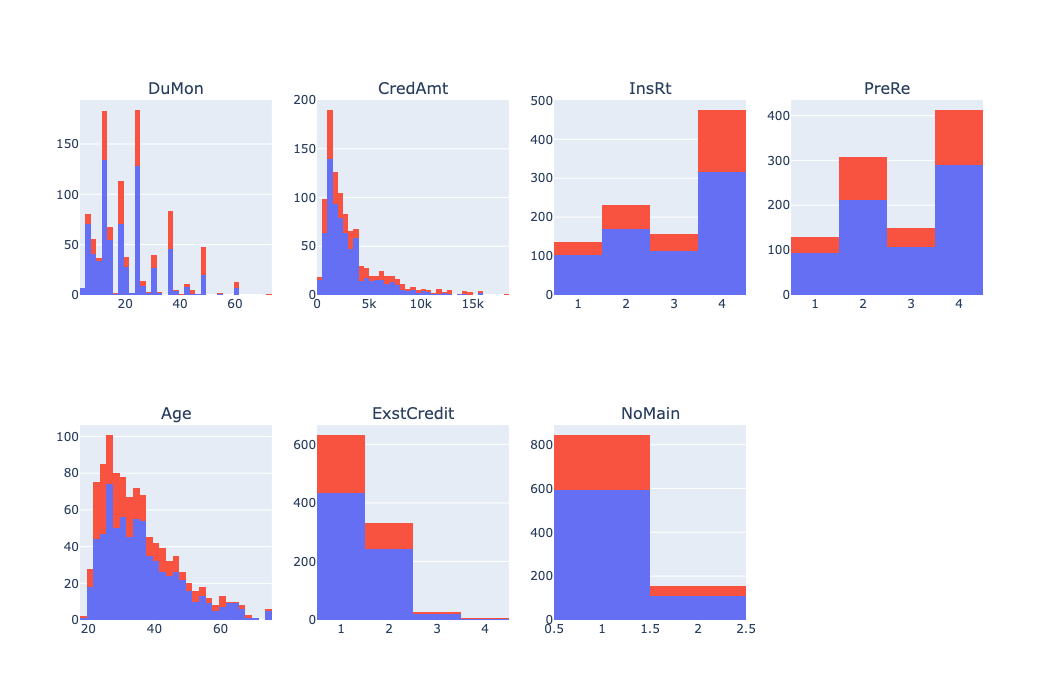

In [177]:
# data distribution for numeric variables
col = 4
row = len(x_num_fts)//col + 1
fig = make_subplots(rows =  row, cols=col, subplot_titles = x_num_fts)
for i, obj in enumerate(x_num_fts):
    fig.add_trace(go.Histogram(x = df_raw[df_raw[y_label]==0][obj] , marker_color = '#656FF4'), row=i//col + 1, col=i%col + 1)
    fig.add_trace(go.Histogram(x = df_raw[df_raw[y_label]==1][obj] , marker_color = '#F85341'), row=i//col + 1, col=i%col + 1)
fig.update_layout(height=row*350, width=col*350, showlegend=False, barmode='stack')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

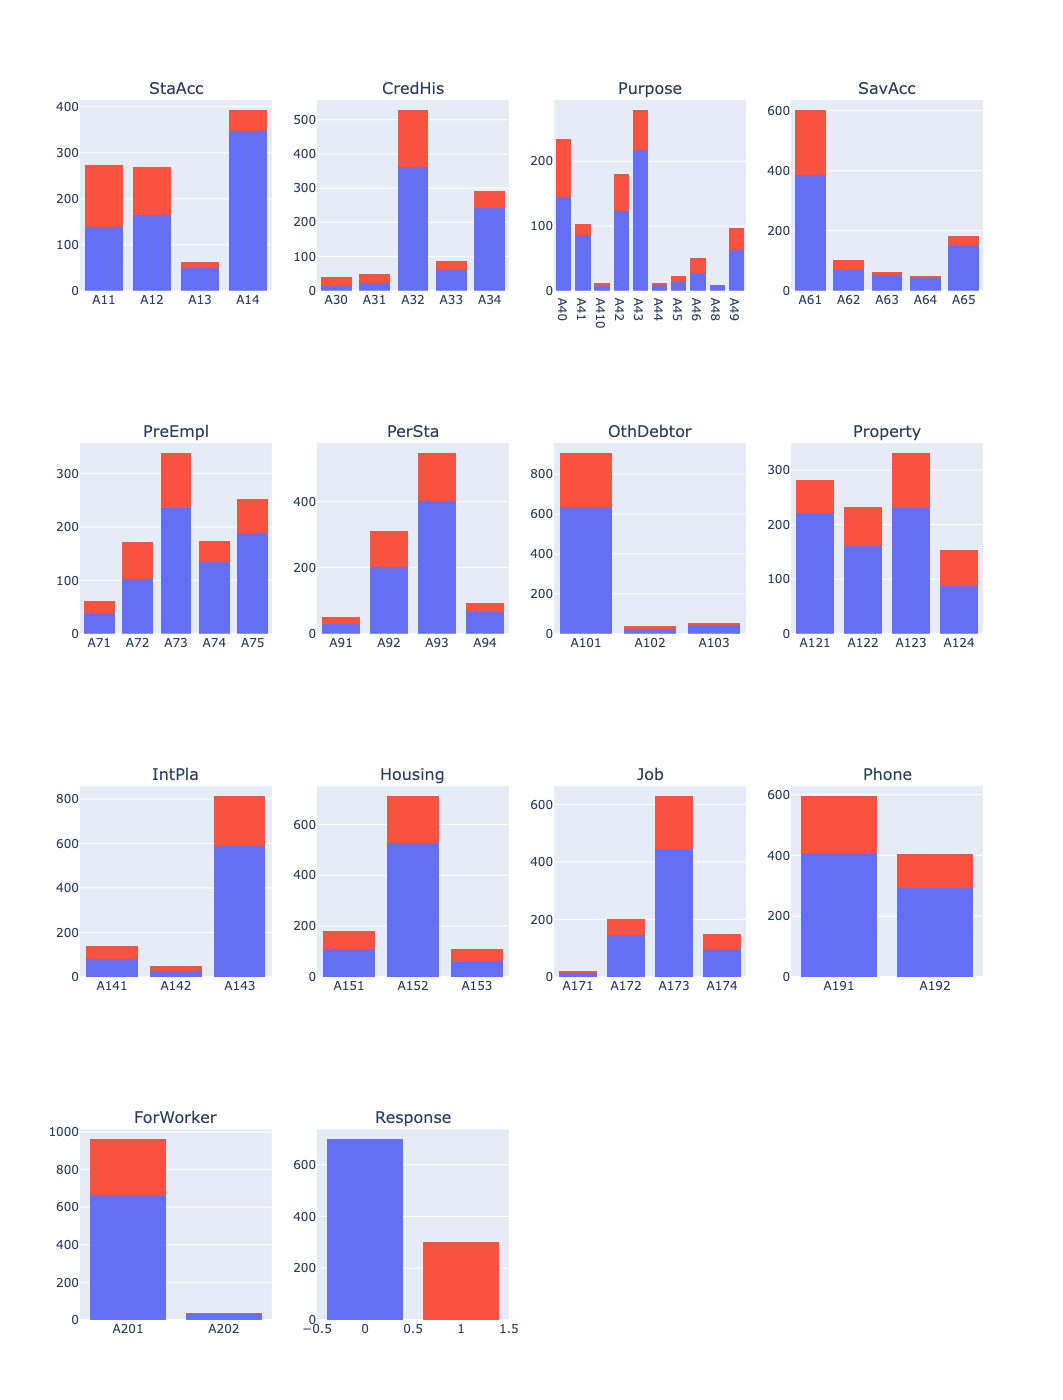

In [178]:
# data distribution for categorical variables
# data distribution for numeric variables
obj_ls = x_cat_fts + [y_label]

col = 4
row = len(obj_ls)//col + 1
fig = make_subplots(rows =  row, cols=col, subplot_titles = obj_ls)
for i, obj in enumerate(obj_ls):
    fig.add_trace(go.Histogram(x = df_raw[df_raw[y_label]==0][obj] , marker_color = '#656FF4'), row=i//col + 1, col=i%col + 1)
    fig.add_trace(go.Histogram(x = df_raw[df_raw[y_label]==1][obj] , marker_color = '#F85341'), row=i//col + 1, col=i%col + 1)
fig.update_layout(height=row*350, width=col*350, showlegend=False, bargap=0.2, barmode='stack')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

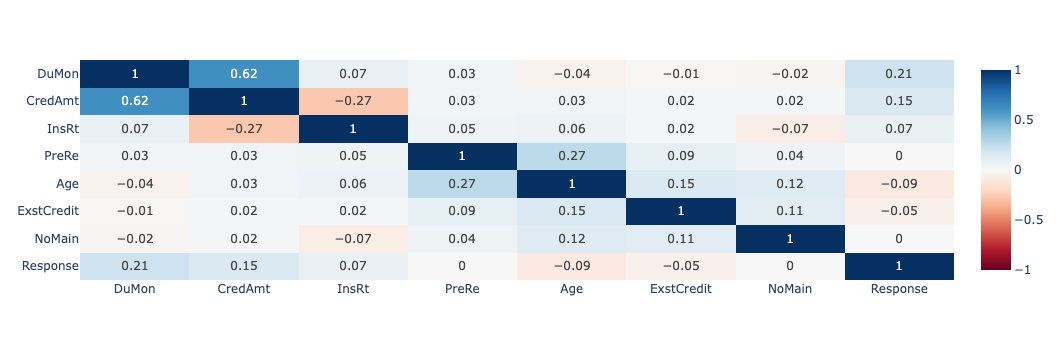

In [179]:
# data correlation heatmap
fig = px.imshow(df_raw[x_num_fts + [y_label]].corr().round(2), 
                text_auto=True,
                zmin=-1,
                zmax=1,
                color_continuous_scale=px.colors.diverging.RdBu,
                aspect="auto"
               )
fig.show()

/Users/khongdat/miniforge3/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



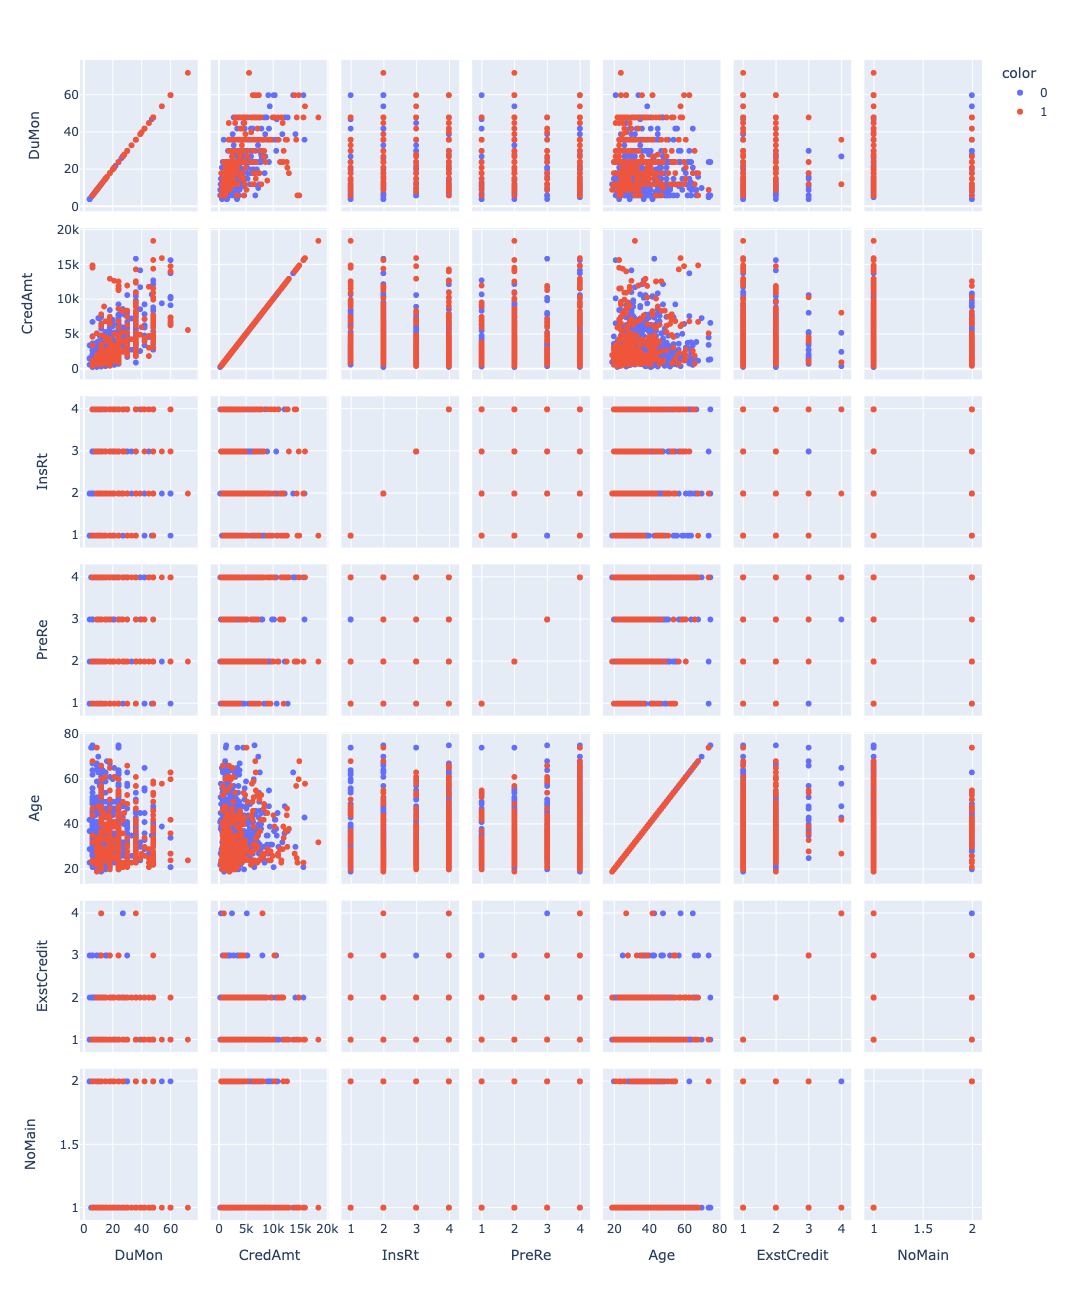

In [180]:
# scatter plot
fig = px.scatter_matrix(df_raw,
                        dimensions=x_num_fts,
                        color=df_raw[y_label].astype(str),
                        width=1300,
                        height=1300)
fig.update_layout(autosize=True)
fig.show()

## train_test_validation split
- Tập `train` + `val`: Huấn luyện mô hình. Chúng ta có thể huấn luyện mô hình trên tập train theo phương pháp cross validation. Khi đó tập validation sẽ được tách ra từ tập train để đánh giá độc lập hiệu suất của mô hình và kiểm tra các hiện tượng overfitting và underfitting.
- Tập `test`: Đánh giá lại mô hình trên những dữ liệu mới và khắc phục các sự cố mô hình như overfitting, underfitting.
- Tập `dev`: Đánh giá mô hình để đưa ra các quyết định lựa chọn siêu tham số phù hợp cho từng lớp mô hình.

Chúng ta thắc mắc nếu đã có tập validation thì tại sao lại cần thêm tập test? Tập test là một tập được lựa chọn sao cho phân phối và tính chất giống với dữ liệu thực tế nhất. Mục tiêu của tập này là để kiểm tra hiệu năng của mô hình nếu triển khai trên production. Thông thường kích thước tập test được lấy bằng tập validation. Để lựa chọn mô hình nào tốt nhất chúng ta sẽ căn cứ trên kết quả đánh giá trên tập test.

In [181]:
# Lựa chọn stratify=df['Response'] để giúp cân bằng tỷ lệ Good/Bad trên cả train và test.
X_train, X_test, y_train, y_test = train_test_split(df_raw[x_label], df_raw[y_label], test_size=0.2 , stratify=df_raw[y_label])
print('train:', X_train.shape, y_train.shape)
print('test:', X_test.shape, y_test.shape)

train: (800, 20) (800,)
test: (200, 20) (200,)


## preprocessing model
Include steps:
- For categorical features:
    - Remove outliers
    - Handle missing values
    - Encoding to numeric datatype
- For numeric features:
    - Remove outliers
    - Handle missing values
    - Scaling (MinMaxScaler, Standardscaler,...)
    

In [212]:
# Pipeline xử lý cho biến categorical
cat_pl= Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Xử lý missing data bằng cách thay thế most frequent
        ('onehot', OneHotEncoder()), # Biến đổi giá trị của biến phân loại thành véc tơ OneHot
    ]
)

# Pipeline xử lý cho biến liên tục
num_pl = Pipeline(
    steps=[
           ('imputer', KNNImputer(n_neighbors=7)), # Xử lý missing data bằng cách dự báo KNN với n=7.
           ('scaler', StandardScaler()) # Xử lý missing data bằng MinMax scaler
    ]
)


# tao 1 pipeline xử lý chung bằng việc combine categorical và numeric pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, x_num_fts), # áp dụng pipeline cho biến liên tục áp dụng cho biến thuộc x_num_fts
        ('cat', cat_pl, x_cat_fts), # áp dụng pipeline cho biến phân loại áp dụng cho biến thuộc x_cat_fts
    ]
)

# or use make_column_selector can select columns based on datatype or the columns name with a regex
preprocessor2 = make_column_transformer(
    (num_pl, make_column_selector(dtype_include=np.number)),
    (cat_pl, make_column_selector(dtype_include=object)),
)

`Pipeline` là một tuple gồm hai phần tử. Phần tử đầu tiên là tên của bước xử lý và phần tử thứ hai là phương pháp xử lý tương ứng. 
Việc đặt tên cho bước xử lý sẽ giúp ta nắm bắt được thứ tự và kiểm soát toàn bộ quá trình xử lý.

## Modelling and score metrics

### Score metric for regression

Trong bài toán dự báo thì chúng ta muốn sai số giữa giá trị dự báo và giá trị thực tế là nhỏ nhất thường lựa chọn các metrics:

* MSE: Trung bình tổng bình phương sai số giữa giá trị dự báo và thực tế.
$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y}_i)^2$$

* RMSE: Khai căn bậc hai của MSE và nó đại diện cho độ lệch giữa giá trị dự báo và thực tế.
$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y}_i)^2)}$$

* MAE: Trung bình trị tuyệt đối của sai số giữa giá trị dự báo và thực tế.
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i-\hat{y}_i|$$

* MAPE: Trung bình của tỷ lệ phần trăm sai số tuyệt đối giữa giá trị dự báo và thực tế.
$$\text{MAPE} = \frac{1}{n}\sum_{i=1}^{n} |\frac{y_i-\hat{y}_i}{y_i}|$$

**Chú ý** : Bài toán **logistic** bản chất là 1 bài toán `regression` bới output của model là dự báo xác suất (giá trị `continuous`), kết hợp cùng với `cutpoint` để phân loại nhành kết quả nhị phân `Positive`/`Negetive`. Tuy nhiên `target` của bài toán là nhị phân 0/1 nên kết hợp điều chỉnh `cutpoint` và đánh giá kết hợp theo nhiều metrics.

### Score metrics for classification

Lấy ví dụ một bài toán phân loại nhị phân có bảng chéo thống kê kết quả giữa thực tế và dự báo như sau:

![](https://phamdinhkhanh.github.io/assets/images/20200813_ModelMetric/pic1.png)

Các chỉ số TP, FP, TN, FN lần lượt có ý nghĩa là :

* TP (True Positive): Tổng số trường hợp dự báo khớp Positive.
* TN (True Negative): Tổng số trường hợp dự báo khớp Negative.
* FP (False Positive): Tổng số trường hợp dự báo các quan sát thuộc nhãn Negative thành Positive. Những sai lầm của False Positive tương ứng với sai lầm loại I (_type I error_), chấp nhận một điều sai. Thực tế cho thấy sai lầm loại I thường gây hậu quả nghiêm trọng hơn so với sai lầm loại II được tìm hiểu bên dưới.
* FN (False Negative): Tổng số trường hợp dự báo các quan sát thuộc nhãn Positive thành Negative. Trong trường hợp này chúng ta mắc sai lầm loại II (_type II error_), bác bỏ một điều đúng.

Đối với bài toán phân loại thì ta quan tâm tới độ chính xác dự báo trên toàn bộ bộ dữ liệu là bao nhiêu? do đó thước đo phổ biến nhất là `accuracy`. 

$$\text{Accuracy} = \frac{TP+TN}{\text{total sample}} = \frac{55+850}{1000} = 90.5 \%$$

**Bài tập:** Bạn hãy giải thích vì sao trong trường hợp mất cân bằng dữ liệu thì accuracy không còn là thước đo mô hình tốt?

Trong tính huống mô hình bị mất cân bằng thì accuracy không còn là thước đo tốt nên được thay thế bằng `precision, recall`. 

$$\text{Precision} = \frac{TP}{\text{total predicted positive}} = \frac{TP}{TP+FP} = \frac{55}{55+50} = 52.4 \%$$

$$\text{Recall} = \frac{TP}{\text{total actual positive}} = \frac{TP}{TP+FN} = \frac{55}{55+45}=55 \%$$

Hai chỉ số này lần lượt giúp đánh giá tỷ lệ dự báo chính xác positive trên tổng số trường hợp được dự báo là positive và tỷ lệ dự báo chính xác positive trên thực tế. Thực sự rất khó để nói lựa chọn `precision` hay `recall` là tốt hơn nên chúng ta dùng `f1-score` là trung bình điều hoà đại diện cho cả precision và recall. Ngoài ra còn một số chỉ số nâng cao hơn cũng được lựa chọn để đánh giá sức mạnh phân loại như `AUC, Gini Index, Cohen's Kappa` tuy nhiên `f1-score` và `accuracy` theo mình nghĩ vẫn là hai chỉ số cơ bản nhất cho bài toán phân loại mà bạn cần nắm vững.

$$f_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$$

$f_{\beta}$ là trường hợp tổng quát hơn của $f_1$ khi ta coi mức độ quan trọng của `recall` bằng $\beta^2$ lần `precision`.

$$\begin{eqnarray}
f_{\beta} & = & \frac{1+\beta^2}{\frac{1}{\text{precision}} + \frac{\beta^2}{\text{recall}}} \\
& = & \frac{(1+\beta^2) \times \text{precision} \times \text{recall}}{\beta^2 \text{precision}+\text{recall}} \\
& = & \frac{(1+\beta^2)\times\text{TP}}{(1+\beta^2)\times\text{TP}+\beta^2 \times \text{FN} + \text{FP}}
\end{eqnarray}$$

In [202]:
# lựa chọn f-score metric để đánh giá model với imbalance data và kết hợp được đánh giá precision and recall
# Với bài toán phân loại khách hành good/bad, tránh phân loại khách hàng BAD thành Good hơn là good thành bad, do đó ưu tiên Recall 
# giả sử Recall ưu tiên gấp 5 lần Precision, tức B^2 = 5

def fbeta(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta = np.sqrt(5))

### Train on model

In [213]:
# model Random Forest classifier
model = RandomForestClassifier()

# Completed training pipeline
completed_pl = Pipeline(
    steps=[
            ("preprocessor", preprocessor), 
            ("classifier", model)
    ]
)

# training
completed_pl.fit(X_train, y_train)

# accuracy
y_train_pred = completed_pl.predict(X_train)
print(f"fbeta on train: {fbeta(list(y_train), list(y_train_pred)):.2f}")

y_pred = completed_pl.predict(X_test)
print(f"fbeta on test: {fbeta(list(y_test), list(y_pred)):.2f}")

fbeta on train: 1.00
fbeta on test: 0.41


--> model bị overfitting

### Cross-validation and single-model
Để thực hiện cross validation chúng ta sử dụng class `RepeatedStratifiedKFold`() với `n_splits` là số lần chia dữ liệu và `n_repeates` là số lần lặp lại quá trình cross validation. Như vậy chúng ta sẽ có tổng cộng `n_splits` x `n_repeats` lượt đánh giá dữ liệu.

Hàm `cross_val_score`() sẽ được sử dụng để tính toán thước đo mô hình trên các lượt huấn luyện.

In [216]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# cross-validation generator với số fold = 10, số lần repeat = 3 ==> tổng có 30 lần chạy model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# tạo metric scorer cho cv
metric = make_scorer(fbeta)
# đánh giá model qua cv
scores = cross_val_score( completed_pl, X_train, y_train, scoring = metric, cv = cv, n_jobs = -1 )
print('Mean f-beta score: {:.03f} ({:.03f})'.format(scores.mean(), scores.std()) )

Mean f-beta score: 0.440 (0.087)


### Cross-validation and multi-models

In [217]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# list các mô hình được lựa chọn
models = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), MLPClassifier(), RandomForestClassifier()]

# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
all_scores = []
for model in models:
    completed_pl = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', model)]    )
    scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    all_scores.append(scores)

/Users/khongdat/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/khongdat/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/khongdat/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/khongdat/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/khongdat/mini

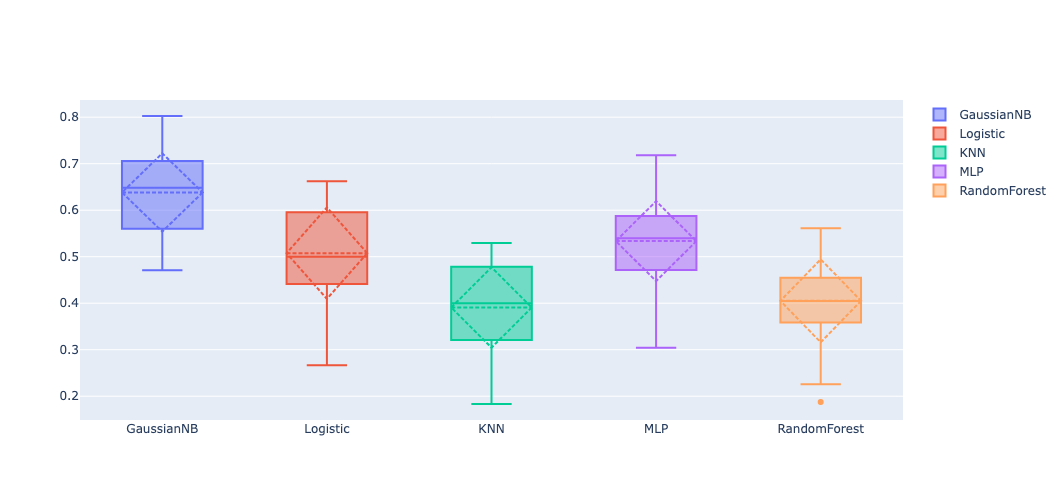

In [224]:
model_names = ['GaussianNB', 'Logistic', 'KNN', 'MLP', 'RandomForest']

fig = go.Figure()
for i, model_name in enumerate(model_names):
    fig.add_trace(
        go.Box(
            y = all_scores[i],
            name = model_name,
            boxmean='sd' # represent mean and standard deviation
    ))
fig.update_layout(height = 500)
fig.show()

### GridSearch
GridSearch là một kỹ thuật giúp tìm kiếm tham số phù hợp cho mô hình đối với một bộ dữ liệu cụ thể. Trong sklearn chúng ta có thể sử dụng GridSearchCV để tạo không gian tham số.

In [264]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

#  tạo lớp ModelSwitcher thông qua BaseEstimator để có thể switch qua multi-model
class ModelSwitcher(BaseEstimator):
    def __init__(self, estimator = RandomForestClassifier() ):
        self.estimator = estimator
        
    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)
    

# tạo pipeline với model là ModelSwitcher
pipeline = Pipeline( steps=[("pre", preprocessor), ("clf", ModelSwitcher())])

# thiết kế parameter cho từng loại model
# "__" tương đương với "." sau khi thông dịch: clf__estimator__penalty --> clf.estimator.penalty
para = [
    {
        'clf__estimator': [LogisticRegression()], # SVM if hinge loss / logreg if log loss
        'clf__estimator__solver':['liblinear','lbfgs'],
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__tol': [1e-4]
    },
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators' : [10, 20, 50, 100, 150],
        'clf__estimator__max_depth': [5, 10, 20],
        'clf__estimator__criterion': ['gini','entropy']
    },
    {
        'clf__estimator': [GaussianNB()],
    },
    {
        'clf__estimator': [MLPClassifier()],
        'clf__estimator__solver': ['lbfgs','adam'],  
        'clf__estimator__alpha': 10.0 ** -np.arange(1, 7), 
        'clf__estimator__hidden_layer_sizes':np.arange(10, 15),
        'clf__estimator__activation': ['logistic', 'tanh', 'relu'],
        'clf__estimator__alpha': [0.0001, 0.001, 0.005],
    },
]


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
metric = make_scorer(fbeta)

gscv = GridSearchCV(pipeline, para, cv=cv, n_jobs=-1, scoring=metric, return_train_score=False, verbose=1)
gscv.fit(X_train, y_train)

Fitting 15 folds for each of 127 candidates, totalling 1905 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=7)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['DuMon',
                                                                          'CredAmt',
                                                                          'InsRt',
                                                                          'PreRe',
                                                                          'Age',
                                                                          'ExstCredit',
                                                                          'NoMain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer...
                          'clf__estimator__n_estimators': [10, 20, 50, 100,
                                                           150]},
                         {'clf__estimator': [GaussianNB()]},
                         {'clf__estimator': [MLPClassifier()],
                          'clf__estimator__activation': ['logistic', 'tanh',
                                                         'relu'],
                          'clf__estimator__alpha': [0.0001, 0.001, 0.005],
                          'clf__estimator__hidden_layer_sizes': array([10, 11, 12, 13, 14]),
                          'clf__estimator__solver': ['lbfgs', 'adam']}],
             scoring=make_scorer(fbeta), verbose=1)

In [265]:
gscv.best_estimator_

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DuMon', 'CredAmt', 'InsRt',
                                                   'PreRe', 'Age', 'ExstCredit',
                                                   'NoMain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['StaAcc', 'CredHis',
                                                   'Purpose', 'SavAcc',
                                                   'PreEmpl', 'PerSta',
                                                   'OthDebtor', 'Property',
                                                   'IntPla', 'Housing', 'Job',
                                                   'Phone', 'ForWorker'])])),
                ('clf', ModelSwitcher(estimator=GaussianNB()))])

In [266]:
gscv.best_params_

{'clf__estimator': GaussianNB()}

In [267]:
gscv.best_score_

0.6608278239039128

In [268]:
fbeta(y_test, gscv.predict(X_test))

0.6201550387596899